In [1]:
import mastermat
import load_PSFs
import one_shot_svd

from matplotlib import pyplot as plt
import numpy as np

First, you would make the master matrix by making a meta-manager which knows about the location of each PSF, and then using these locations in combination with the PSFs to do a singular value decomposition thereof. Normalizing the results of the singular value decomposition, you would get a matrix of kernels and a matrix of weights, which, when multiplied together, should give a matrix whose columns can be shifted up and down to make the final mastermat.

Making the mastermat need be done only, after which it can be loaded from disk.

In [2]:
# psfs_directory = "/home/dshteinbok/nV3_PSFs_flat"
psfs_directory = "../data/nV3_PSFs_flat"
# psf_meta_path = "/home/dshteinbok/nV3_PSFs_flat_meta/metafile.csv"
psf_meta_path = "../data/nV3_PSFs_flat_meta/metafile.csv"
img_dims = (800, 1280)
obj_dims = (640, 1024)
metaman = load_PSFs.MetaMan(psf_meta_path) 

In [3]:
# I wrote a function in the mastermat library that specifically makes and saves these mastermats
# mastermat.make_mastermat_save(psfs_directory, psf_meta_path, img_dims, obj_dims)

In [4]:
# %debug
shifts = one_shot_svd.interpolate_shifts(metaman, img_dims, obj_dims, method='cubic')

In [5]:
shifts.shape

(1024000, 2)

In [6]:
np.any(np.isnan(shifts))

True

In [7]:
shifts.dtype

dtype('float64')

In [8]:
shifts

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]])

In [9]:
# a 1024000-entry 1d vector that contains the booleans of whether a row only has numbers
row_selector = (~np.isnan(shifts[:,0]))*(~np.isnan(shifts[:,1]))

In [10]:
row_selector

array([False, False, False, ..., False, False, False])

In [11]:
shifts_int = shifts.astype(int)[row_selector]

In [12]:
# convert shifts from 2d array to 1d array using modular encodings.
shifts_mod = shifts_int[:,0]*img_dims[1] + shifts_int[:,1] #+ img_dims[0]//2 + img_dims[1]//2
# nans should just propogate through greedily

In [13]:
shifts_mod

array([  18024,   18025,   18026, ..., 1005972, 1005972, 1005973])

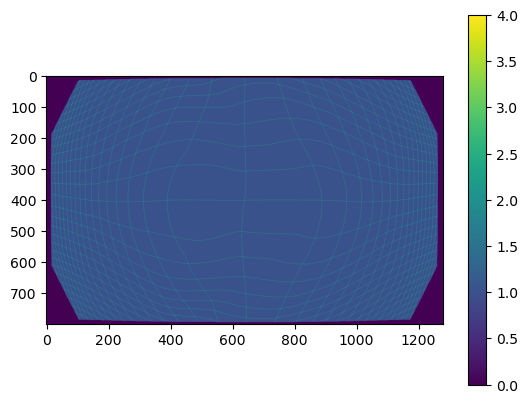

In [14]:
# Don't care about indices, so just grab all the non-nan vals
shifts_mod_num = shifts_mod[~np.isnan(shifts_mod)]

# now bincount, plot
shift_ends = np.bincount(shifts_mod_num, minlength=1024000)

plt.imshow(shift_ends.reshape((800,1280)))
plt.colorbar()

## Where do the damned lines come from?
We hereby begin an analysis of the lines, going by the points on the image to which multiple object points are focused

In [15]:
# to generate vertical lines for the "newline" points:
# %debug
newline_flags = np.zeros(img_dims, dtype=int)
newline_flags[:,0] = 1
newline_flags = np.ravel(newline_flags)
# newline_inds = np.empty(np.sum(newline_flags))
newline_inds = np.arange(newline_flags.shape[0])[newline_flags==1]

In [16]:
newline_inds

array([      0,    1280,    2560,    3840,    5120,    6400,    7680,
          8960,   10240,   11520,   12800,   14080,   15360,   16640,
         17920,   19200,   20480,   21760,   23040,   24320,   25600,
         26880,   28160,   29440,   30720,   32000,   33280,   34560,
         35840,   37120,   38400,   39680,   40960,   42240,   43520,
         44800,   46080,   47360,   48640,   49920,   51200,   52480,
         53760,   55040,   56320,   57600,   58880,   60160,   61440,
         62720,   64000,   65280,   66560,   67840,   69120,   70400,
         71680,   72960,   74240,   75520,   76800,   78080,   79360,
         80640,   81920,   83200,   84480,   85760,   87040,   88320,
         89600,   90880,   92160,   93440,   94720,   96000,   97280,
         98560,   99840,  101120,  102400,  103680,  104960,  106240,
        107520,  108800,  110080,  111360,  112640,  113920,  115200,
        116480,  117760,  119040,  120320,  121600,  122880,  124160,
        125440,  126

In [17]:
newline_inds_selected = (np.arange(newline_flags.shape[0])[(newline_flags==1)*row_selector])

In [18]:
newline_inds_selected

array([230400, 231680, 232960, 234240, 235520, 236800, 238080, 239360,
       240640, 241920, 243200, 244480, 245760, 247040, 248320, 249600,
       250880, 252160, 253440, 254720, 256000, 257280, 258560, 259840,
       261120, 262400, 263680, 264960, 266240, 267520, 268800, 270080,
       271360, 272640, 273920, 275200, 276480, 277760, 279040, 280320,
       281600, 282880, 284160, 285440, 286720, 288000, 289280, 290560,
       291840, 293120, 294400, 295680, 296960, 298240, 299520, 300800,
       302080, 303360, 304640, 305920, 307200, 308480, 309760, 311040,
       312320, 313600, 314880, 316160, 317440, 318720, 320000, 321280,
       322560, 323840, 325120, 326400, 327680, 328960, 330240, 331520,
       332800, 334080, 335360, 336640, 337920, 339200, 340480, 341760,
       343040, 344320, 345600, 346880, 348160, 349440, 350720, 352000,
       353280, 354560, 355840, 357120, 358400, 359680, 360960, 362240,
       363520, 364800, 366080, 367360, 368640, 369920, 371200, 372480,
      

In [19]:
# horizontal lines for pixels where bincount > 3 in range of 200-210
shift_ends_big = np.arange(1024000)[shift_ends>3]

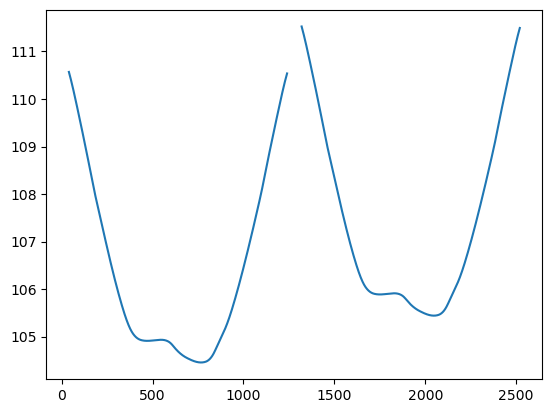

In [20]:
plt.plot(shifts[100*1280:102*1280,0])

Below is my masterpiece! X-axis and Y-axis each represent unique pixel number. The X-axis is the set of unique pixel numbers in the input (object), while the Y-axis represents the unique pixel number of the output (image). Each point shows that the PSF generated by the input pixel is centered on the output pixel.

Each vertical blue line represents a newline, while a horizontal line represents a point to which more than 3 input pixels are focused. The horizontal lines thus represent the "bright spots" in the ones-image, and the emergent behaviour is the warped gridlines that we see. 

257280
258560
259840
261120
262400
263680
264960
266240
267520


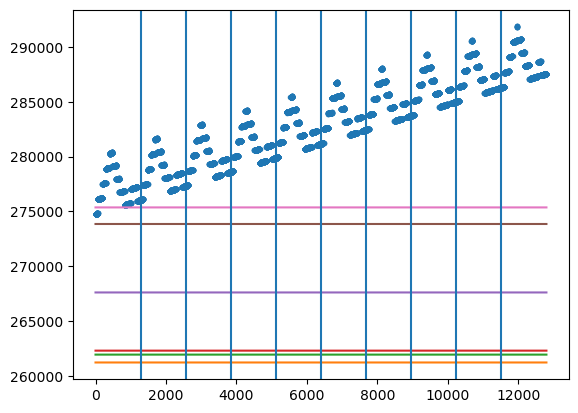

In [29]:
# plt.plot((1280*shifts[:,0] + shifts[:,1])[200*1280:210*1280], '.')
# plt.plot((img_dims[1]*shifts[:,0] + shifts[:,1])[100*1280:102*1280])
plt.plot(shifts_mod[200*1280:210*1280], '.')
for sebind in shift_ends_big[(shift_ends_big > 260000)*(shift_ends_big < 277500)]:
# for sebind in shift_ends_big[(shift_ends_big > 275000)*(shift_ends_big < 290000)]:
# for sebind in shift_ends_big[(shift_ends_big > 134000)*(shift_ends_big < 144000)]:
    plt.plot(np.ones(10*1280)*sebind)
# for nlind in newline_inds_selected[(newline_inds_selected > 200*1280) * (newline_inds_selected < 210*1280)]:
for nlind in newline_inds[(newline_inds > 200*1280) * (newline_inds < 210*1280)]:
# for nlind in newline_inds_selected:
    plt.axvline(x=nlind-200*1280)
    print(nlind)

In the image above it looks like the range of output pixels spanned in a horizontal sweep of the image is a lot greater than the difference from row to row, which is (probably?) the inverse of what's expected. Curious to see what happens if we flip the x- and y-values of the shift...

In [22]:
# shifts_mod_inv = shifts_int[:,0] + shifts_int[:,1]*img_dims[1] 

# plt.plot(shifts_mod_inv[200*1280:210*1280], '.')
# # for sebind in shift_ends_big[(shift_ends_big > 260000)*(shift_ends_big < 277500)]:
# for sebind in shift_ends_big[(shift_ends_big > 275000)*(shift_ends_big < 290000)]:
# # for sebind in shift_ends_big[(shift_ends_big > 134000)*(shift_ends_big < 144000)]:
#     plt.plot(np.ones(10*1280)*sebind)
# for nlind in newline_inds_selected[(newline_inds_selected > 200*1280) * (newline_inds_selected < 210*1280)]:
# # for nlind in newline_inds_selected:
#     plt.axvline(x=nlind-200*1280)
#     print(nlind)

Nah, this is much more wrong. The large range could be explicable because circular warping does imply that y-shift may vary as you scan along the horizontal. This y-shift variation would definitely manifest as large jumps in pixel number, because a $\Delta y$ really is manifested as a 1280-fold jump in pixel number

In [23]:
# at what points are 

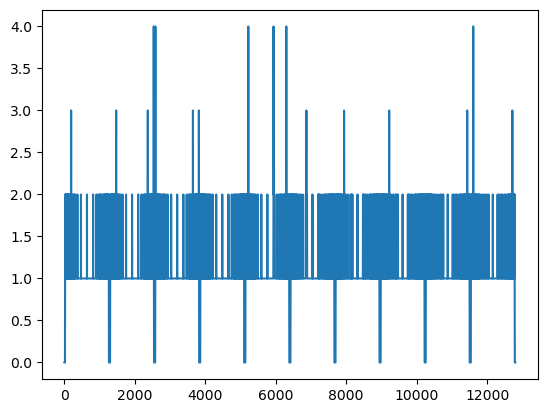

In [24]:
# plt.imshow(np.bincount(np.int(shifts[:,0])).reshape((800,1280)))
plt.plot(shift_ends[200*1280:210*1280])

A hypothesis is that as you stretch the image inhomogeneously, you end up with a region with e.g. $n-1$ pixels into which you're trying to pack $n$ logical points. By the pigeonhole principle you'll end up with a pixel onto which two points happen to be mapped. It is hypothesized that this is the location of the double-values contributing to the visible gridlines. ~It is further hypothesized that the reason we see the colorbar going up to 4 is that we have 4 pixels mapping to the same point at the corners.~ This was disproven

In [33]:
np.bincount(shift_ends)

array([ 81293, 895269,  46184,    874,    380])

In [ ]:
# interpolate the brightness of a ones-object to image pixels
# i.e. imagine the locations given in the shifts are each a bright spot.
# Rather than "snapping" the bright spot to the closest pixel,
# linearly interpolate what should be the brightness at each pixel between the bright spots

# maybe do this later... seems like a lot more work to do in a computationally efficient manner than what I want to
# with the master matrix